In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [2]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale


import numpy as np
import pandas as pd

In [3]:
#df = pd.read_csv("D:/dataset/cleaned_improved_cicids2017.csv")
df = pd.read_csv("/Users/anchanghun/Downloads/CIC-Dataset/cleaned_improved_cicids2017.csv")

In [4]:
df.head()

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,0,119719148,231,0,0,0,0,0,0.000000,0.000000,...,22509459,17,12685486.0,5.296658e+06,20694308,6499982,0,0,0,BENIGN
1,17,65511209,6,6,288,288,48,48,48.000000,0.000000,...,1506210,1506210,64004884.0,0.000000e+00,64004884,64004884,0,0,0,BENIGN
2,17,113976922,267,0,20447,0,153,37,76.580524,44.140625,...,10983883,14,25498178.0,1.883305e+07,48523116,5463561,0,0,0,BENIGN
3,17,67037196,8,8,384,384,48,48,48.000000,0.000000,...,11034681,11034681,55956316.0,0.000000e+00,55956316,55956316,0,0,0,BENIGN
4,17,68045057,8,8,384,384,48,48,48.000000,0.000000,...,11043596,11043596,56943904.0,0.000000e+00,56943904,56943904,0,0,0,BENIGN


In [5]:
df['Label'].value_counts()

Label
BENIGN                        1594540
Portscan                       159066
DoS Hulk                       158468
DDoS                            95144
Infiltration - Portscan         71767
DoS GoldenEye                    7567
FTP-Patator                      3972
DoS Slowloris                    3859
SSH-Patator                      2961
DoS Slowhttptest                 1740
Botnet                            736
Web Attack - Brute Force           73
Infiltration                       36
Web Attack - XSS                   18
Web Attack - SQL Injection         13
Heartbleed                         11
Name: count, dtype: int64

In [6]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter

# ✅ 사용할 공격 유형 리스트 (BENIGN 포함)
selected_classes = [
    "BENIGN",
    "FTP-Patator",
    "SSH-Patator",
    "DoS Hulk",
    "DoS Slowhttptest",
    "DoS GoldenEye",
    "DoS Slowloris",
    "Portscan",
    "DDoS"
]

# ✅ 데이터 필터링 (`Label` 기준)
df_filtered = df[df['Label'].isin(selected_classes)].copy()

# ✅ X, y 분리 (라벨 인코딩 없이 원본 그대로 유지)
X = df_filtered.drop(columns=['Label'])  # Feature Data
y = df_filtered['Label']  # Target Labels

# ✅ 클래스별 개수 확인
print("Before SMOTE:", Counter(y))

# ✅ BENIGN 클래스 개수 확인
benign_count = Counter(y)["BENIGN"]  # BENIGN 샘플 개수

# ✅ 기존 클래스 개수 저장
target_stats = Counter(y)

# ✅ SMOTE 비율 설정 (BENIGN 개수의 0.75 비율로 맞춤)
sampling_strategy = {}

for cls, count in target_stats.items():
    if cls != "BENIGN":  # BENIGN 제외
        new_count = int(benign_count * 0.5)  # 목표 개수 설정
        if new_count > count:  # 기존 개수보다 클 때만 적용 (SMOTE는 over-sampling만 가능)
            sampling_strategy[cls] = new_count

print("SMOTE Sampling Strategy:", sampling_strategy)

# ✅ SMOTE 적용 (선택한 클래스만 over-sampling)
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# ✅ SMOTE 적용 후 클래스별 개수 확인
print("After SMOTE:", Counter(y_resampled))

# ✅ 최종 데이터 프레임 생성
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['Label'] = y_resampled  # 원래 라벨 복원

# ✅ 최종 데이터 확인
df_resampled.head()

Before SMOTE: Counter({'BENIGN': 1594540, 'Portscan': 159066, 'DoS Hulk': 158468, 'DDoS': 95144, 'DoS GoldenEye': 7567, 'FTP-Patator': 3972, 'DoS Slowloris': 3859, 'SSH-Patator': 2961, 'DoS Slowhttptest': 1740})
SMOTE Sampling Strategy: {'FTP-Patator': 1195905, 'SSH-Patator': 1195905, 'DoS Slowloris': 1195905, 'DoS Slowhttptest': 1195905, 'DoS Hulk': 1195905, 'DoS GoldenEye': 1195905, 'Portscan': 1195905, 'DDoS': 1195905}


/opt/homebrew/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


After SMOTE: Counter({'BENIGN': 1594540, 'FTP-Patator': 1195905, 'SSH-Patator': 1195905, 'DoS Slowloris': 1195905, 'DoS Slowhttptest': 1195905, 'DoS Hulk': 1195905, 'DoS GoldenEye': 1195905, 'Portscan': 1195905, 'DDoS': 1195905})


,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,0,119719148,231,0,0,0,0,0,0.000000,0.000000,...,22509459,17,12685486.0,5.296658e+06,20694308,6499982,0,0,0,BENIGN
1,17,65511209,6,6,288,288,48,48,48.000000,0.000000,...,1506210,1506210,64004884.0,0.000000e+00,64004884,64004884,0,0,0,BENIGN
2,17,113976922,267,0,20447,0,153,37,76.580524,44.140625,...,10983883,14,25498178.0,1.883305e+07,48523116,5463561,0,0,0,BENIGN
3,17,67037196,8,8,384,384,48,48,48.000000,0.000000,...,11034681,11034681,55956316.0,0.000000e+00,55956316,55956316,0,0,0,BENIGN
4,17,68045057,8,8,384,384,48,48,48.000000,0.000000,...,11043596,11043596,56943904.0,0.000000e+00,56943904,56943904,0,0,0,BENIGN


In [7]:
df=df_resampled

In [8]:
# ✅ 원래 데이터에서 라벨 매핑 찾기
unique_labels = df['Label'].unique()  # 원본 Label 목록
encoded_labels = sorted(df['Label'].astype('category').cat.codes.unique())  # 인코딩된 라벨 목록

# ✅ 라벨 인코딩 매핑 생성 (숫자 → 원본 라벨)
label_mapping = {encoded: original for encoded, original in zip(encoded_labels, unique_labels)}

# ✅ 라벨 인코딩 매핑 출력
print("Label Encoding Mapping:")
for encoded, original in label_mapping.items():
    print(f"{encoded} → {original}")

Label Encoding Mapping:
0 → BENIGN
1 → FTP-Patator
2 → SSH-Patator
3 → DoS Slowloris
4 → DoS Slowhttptest
5 → DoS Hulk
6 → DoS GoldenEye
7 → Portscan
8 → DDoS


In [9]:
from sklearn.preprocessing import LabelEncoder

# 라벨 인코딩 적용
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

# 원래 라벨과 인코딩된 값의 매핑 출력
label_mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))
print("라벨 매핑:", label_mapping)

# 인코딩된 데이터프레임 확인
print(df['Label'].value_counts())

라벨 매핑: {0: 'BENIGN', 1: 'DDoS', 2: 'DoS GoldenEye', 3: 'DoS Hulk', 4: 'DoS Slowhttptest', 5: 'DoS Slowloris', 6: 'FTP-Patator', 7: 'Portscan', 8: 'SSH-Patator'}
Label
0    1594540
6    1195905
8    1195905
5    1195905
4    1195905
3    1195905
2    1195905
7    1195905
1    1195905
Name: count, dtype: int64


In [10]:
len(df.columns)

83

In [11]:
df.shape

(11161780, 83)

In [11]:
df.columns

Index(['Protocol', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets',
       'Total Length of Fwd Packet', 'Total Length of Bwd Packet',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd RST Flags',
       'Bwd RST Flags', 'Fwd Header Length', 'Bwd Header Length',
       'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min',
       'Packet Length Max', 'Packet Length Mean', 'Packet Length Std',
       'Packet Length Variance', 'FIN Flag Count', '

누적 분산 비율 (cumulative explained variance):
[0.20225881 0.32927474 0.43491227 0.5038228  0.56042019 0.60267452
 0.63871218 0.6725229  0.69721428 0.72038439 0.74249147 0.76306168
 0.78257561 0.8009602  0.8181608  0.83474053 0.84951368 0.86361768
 0.87600212 0.88820076 0.89962768 0.91006988 0.91908975 0.92665918
 0.9339231 ]
Label 데이터 타입: int64


/opt/homebrew/anaconda3/envs/myenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/envs/myenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/envs/myenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/envs/myenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/anaconda3/envs/myenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Gly

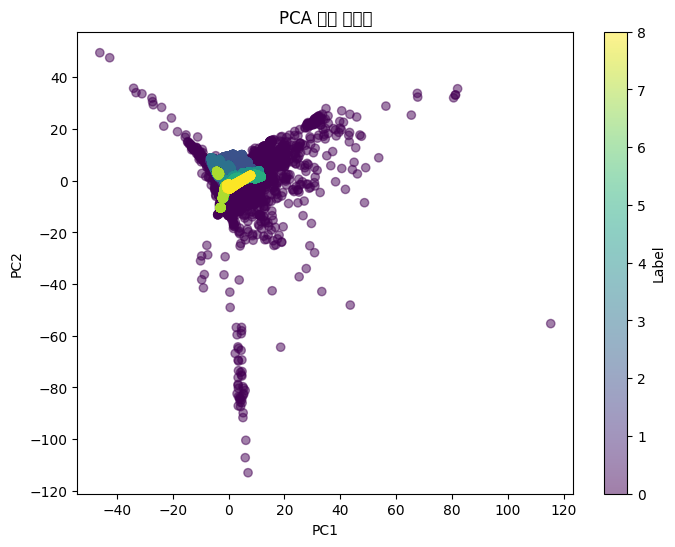

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

tmp = df.drop(labels = 'Label',axis=1)
labels = df['Label']

# 1. 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(tmp)

# 2. PCA 적용 (주성분 개수 설정)
n_components = 25  # 원하는 차원 수로 설정
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)


# 3. PCA 누적 분산 비율 확인
explained_variance_ratio = pca.explained_variance_ratio_.cumsum()
print("누적 분산 비율 (cumulative explained variance):")
print(explained_variance_ratio)

# 4. PCA 결과를 DataFrame으로 변환하고 label 병합
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])
df_merged = X_pca_df.assign(label=labels.values)

# 5. 병합된 데이터 타입 확인
print("Label 데이터 타입:", df_merged['label'].dtype)

# 6. 정렬 여부 확인 (필요하면 추가)
# 확인 예시: 병합 전후 `labels` 순서와 `df_merged['label']`이 동일한지 점검
assert np.array_equal(labels.values, df_merged['label'].values), "Label 순서가 일치하지 않습니다."

# 7. PCA 결과 시각화 (2D로 줄인 경우)
import matplotlib.pyplot as plt
if n_components >= 2:
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA 결과 시각화')
    plt.colorbar(label='Label')
    plt.show()

In [13]:
df_merged

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,label
0,3.133764,-0.057827,1.248250,-4.117257,5.674202,5.806715,-0.359378,2.249757,-0.028880,9.999254,...,6.821195,-1.799280,-0.803589,-1.373265,-0.539204,1.829541,-0.831321,-2.462342,-7.149064,0
1,3.624807,-1.453943,-3.859415,-0.834141,3.254719,-2.539944,0.664026,-1.916499,-0.002530,1.518823,...,-0.308966,-0.303104,0.283252,0.562220,0.465308,-0.349874,-0.094506,0.017954,0.126592,0
2,8.052037,-4.592301,17.363339,-4.419207,5.043979,-2.516102,-1.486898,12.877783,-0.037288,15.100836,...,9.555425,1.387582,-1.684220,-3.391748,7.035431,-1.503136,-6.610427,-2.972832,-9.570041,0
3,4.467709,-0.173854,-1.475338,-2.495462,4.984029,-0.515817,-0.761319,-2.990129,-0.009010,3.985456,...,-3.828014,-5.408885,0.324698,0.572862,0.684857,0.263595,2.388656,0.033267,-0.268378,0
4,4.540170,-0.141949,-1.498072,-2.482330,4.978054,-0.519605,-0.742066,-3.007286,-0.009041,4.002971,...,-3.821991,-5.409454,0.330023,0.583476,0.690970,0.256901,2.384093,0.035130,-0.261214,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11161775,-0.189882,-2.800505,3.457880,1.442843,-1.856648,-2.096892,0.627967,1.207121,0.000245,0.058464,...,0.077609,-0.007046,-0.053687,-0.077721,-0.242274,0.257804,-0.049276,-0.057732,-0.573345,8
11161776,-0.211244,-2.795142,3.457104,1.452630,-1.856272,-2.074369,0.610539,1.214232,0.000147,0.091158,...,0.092351,0.010287,-0.064012,-0.096063,-0.256390,0.268501,-0.077414,-0.054344,-0.538586,8
11161777,-0.191710,-2.763044,3.450089,1.407321,-1.808805,-2.067735,0.619970,1.192345,0.000272,0.041361,...,0.086561,0.009592,-0.060632,-0.092812,-0.246877,0.258841,-0.063190,-0.060928,-0.600101,8
11161778,-0.173800,-2.772752,3.453209,1.424361,-1.829193,-2.081759,0.626227,1.196703,0.000259,0.050527,...,0.083300,0.002967,-0.056140,-0.083311,-0.244360,0.258965,-0.057525,-0.059392,-0.586945,8


In [14]:
df = df_merged

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, test_size=0.1, random_state=42)
X_train.shape, X_test.shape

((10045602, 26), (1116178, 26))

In [16]:
X_train_normal = X_train[X_train['label'] == 0]
X_train_normal.shape

(1434963, 26)

In [17]:
X_test.shape

(1116178, 26)

In [18]:
y_test = X_test['label']
X_test = X_test.drop(labels='label',axis=1)

In [19]:
y_train_normal = X_train_normal['label']
X_train_normal = X_train_normal.drop(labels='label', axis=1)

In [20]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, Conv1D, Conv1DTranspose
from keras.models import Model
from keras import regularizers
from keras_self_attention import SeqWeightedAttention, SeqSelfAttention
from keras.callbacks import EarlyStopping

Epoch 1/50
40359/40359 [==============================] - 154s 4ms/step - loss: 7.2292 - accuracy: 0.8567 - val_loss: 6.5932 - val_accuracy: 0.8896
Epoch 2/50
40359/40359 [==============================] - 169s 4ms/step - loss: 7.1995 - accuracy: 0.8955 - val_loss: 6.5867 - val_accuracy: 0.9054
Epoch 3/50
40359/40359 [==============================] - 168s 4ms/step - loss: 7.1947 - accuracy: 0.9006 - val_loss: 6.5825 - val_accuracy: 0.8893
Epoch 4/50
40359/40359 [==============================] - 171s 4ms/step - loss: 7.1935 - accuracy: 0.8982 - val_loss: 6.5806 - val_accuracy: 0.9044
Epoch 5/50
40359/40359 [==============================] - 165s 4ms/step - loss: 7.1923 - accuracy: 0.8892 - val_loss: 6.5795 - val_accuracy: 0.8840
Epoch 6/50
40359/40359 [==============================] - 173s 4ms/step - loss: 7.1921 - accuracy: 0.8834 - val_loss: 6.5801 - val_accuracy: 0.8782
Epoch 7/50
40359/40359 [==============================] - 172s 4ms/step - loss: 7.1918 - accuracy: 0.8793 - val_

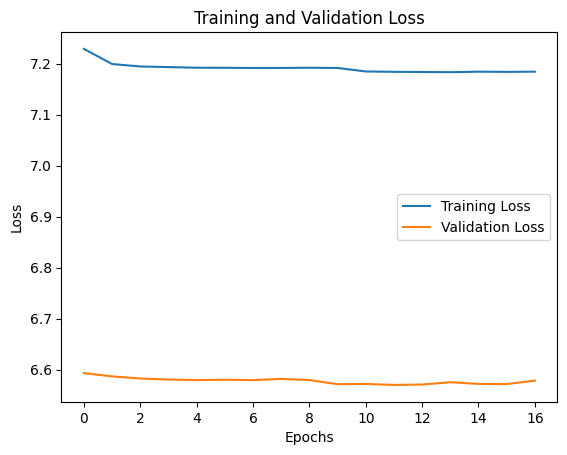

34881/34881 [==============================] - 52s 1ms/step


/var/folders/lt/dt43ws7s4_z4rrsjwvzmwz740000gn/T/ipykernel_16133/2334203644.py:99: RuntimeWarning: invalid value encountered in divide
  sns.heatmap(cm / np.sum(cm, axis=1)[:, np.newaxis], annot=True, fmt=".2f", cmap="gray", xticklabels=labels, yticklabels=labels)


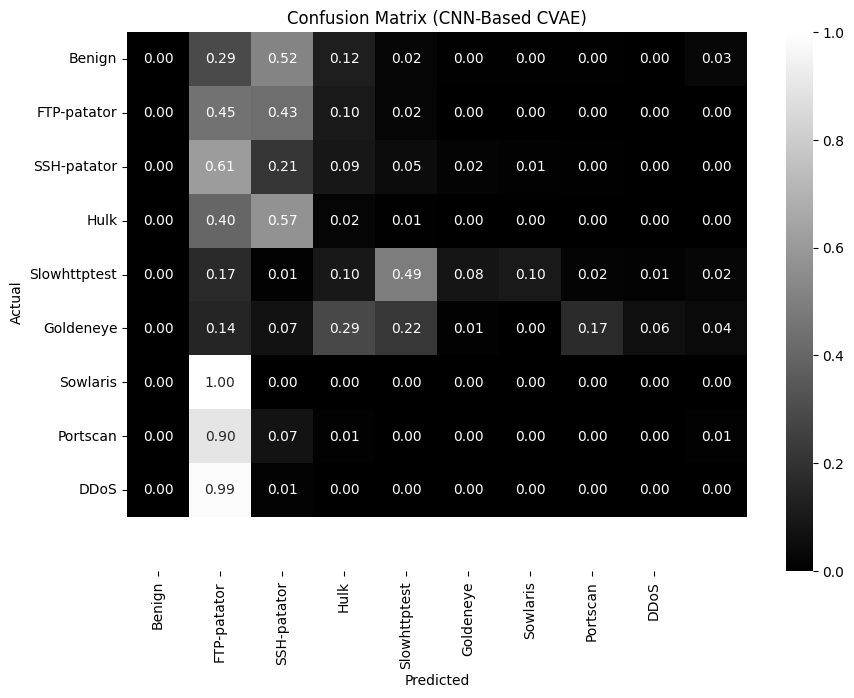

/opt/homebrew/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


🔹 Precision: 0.0969
🔹 Recall: 0.1265
🔹 F1-score: 0.0931


ValueError: Number of classes, 10, does not match size of target_names, 9. Try specifying the labels parameter

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, losses, Model, Input
import numpy as np
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ 클래스 개수 설정 (총 9개: 정상 + 8개 공격)
num_classes = 9

# ✅ 잠재 차원 및 중간 차원 설정
latent_dim = 10
inter_dim = 20

# ✅ 샘플링 함수 (재매개변수화 트릭 사용) -> 안정적인 샘플링 적용
def sampling(args):
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * K.clip(z_log_sigma, -10, 10)) * epsilon  # NaN 방지

# ✅ 안정적인 VAE 손실 함수 (NaN 방지)
def vae_loss(x, x_decoded_mean, z_mean, z_log_sigma):
    reconstruction_loss = K.mean(K.square(x - x_decoded_mean) + 1e-10)  # NaN 방지
    kl_loss = -0.5 * K.sum(1 + K.clip(z_log_sigma, -10, 10) - K.square(z_mean) - K.exp(K.clip(z_log_sigma, -10, 10)), axis=-1)  # 안정화
    kl_loss_weighted = kl_loss * 0.0001  # KL 손실 가중치 적용
    total_loss = K.mean(reconstruction_loss + kl_loss_weighted)
    return total_loss

# ✅ CNN-Based CVAE 모델 정의
def cvae(X):
    features = X.shape[1]  # 특징 수
    input_x = Input(shape=(features,), name='InputFeatures')  

    # CNN 기반 인코더
    reshaped_input = layers.Reshape((features, 1))(input_x)  # 1D Conv 사용을 위한 차원 변환
    h = layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding='same')(reshaped_input)
    h = layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same')(h)
    h = layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same')(h)
    h = layers.Flatten()(h)
    h = layers.Dense(inter_dim, activation='relu')(h)

    # 잠재 공간
    z_mean = layers.Dense(latent_dim, name='z_mean')(h)
    z_log_sigma = layers.Dense(latent_dim, name='z_log_sigma')(h)
    z = layers.Lambda(sampling, name='z')([z_mean, z_log_sigma])

    # 디코더
    decoder1 = layers.Dense(features * inter_dim)(z)
    decoder1 = layers.Reshape((features, inter_dim))(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=16, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=32, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=64, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Flatten()(decoder1)
    decoder1 = layers.Dense(features, activation='sigmoid')(decoder1)  # 최종 복원

    model = Model(input_x, decoder1)
    model.add_loss(vae_loss(input_x, decoder1, z_mean, z_log_sigma))

    return model

# ✅ 정상 데이터만 학습
model = cvae(X_train_normal)  # 정상 데이터로만 학습
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train_normal, X_train_normal,
                    shuffle=True, epochs=50, validation_split=0.1, batch_size=32,
                    callbacks=[early_stopping])



In [29]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_shapes.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


TypeError: 'History' object is not subscriptable

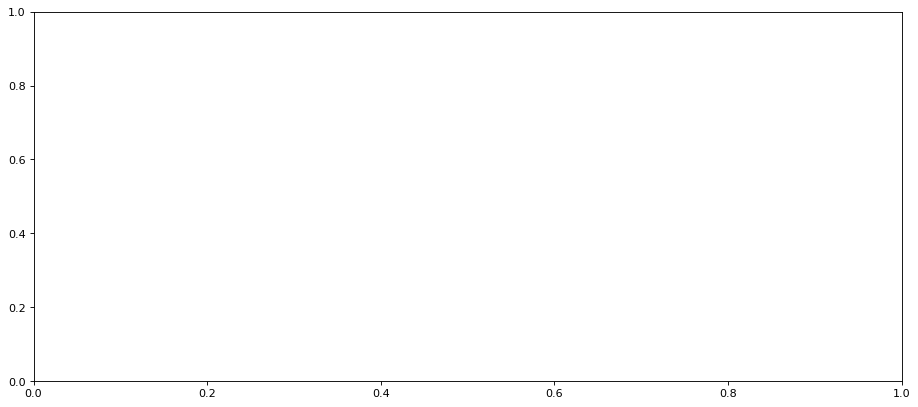

In [35]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [36]:
import pandas as pd

# ✅ `error_df` 생성
error_df = pd.DataFrame({"reconstruction_error": reconstruction_errors, "true_label": y_test})

In [44]:
# ✅ 실제 라벨과 예측 라벨 비교 (디버깅용)
# ✅ 예측 값이 1부터 시작하므로, 1 감소하여 0~8 범위로 맞춤
y_pred_labels = y_pred_labels - 1
print("🔹 Unique y_test values:", np.unique(y_test))
print("🔹 Unique y_pred_labels values:", np.unique(y_pred_labels))

# ✅ Label Mapping 확인
label_mapping = {
    0: "Benign",
    1: "FTP-Patator",
    2: "SSH-Patator",
    3: "DoS Slowloris",
    4: "DoS Slowhttptest",
    5: "DoS Hulk",
    6: "DoS GoldenEye",
    7: "Portscan",
    8: "DDoS"
}

🔹 Unique y_test values: [0 1 2 3 4 5 6 7 8]
🔹 Unique y_pred_labels values: [0 1 2 3 4 5 6 7 8]


In [45]:
# ✅ 정상 데이터만 선택하여 threshold 계산
normal_errors = error_df[error_df["true_label"] == 0]["reconstruction_error"]

# ✅ 여러 임계값을 실험해보기 (90% / 95% / 99%)
threshold_90 = np.percentile(normal_errors, 90)
threshold_95 = np.percentile(normal_errors, 95)
threshold_99 = np.percentile(normal_errors, 99)

print(f"🔹 Threshold (90%): {threshold_90:.4f}")
print(f"🔹 Threshold (95%): {threshold_95:.4f}")
print(f"🔹 Threshold (99%): {threshold_99:.4f}")

# ✅ 최적 Threshold 선택 (95% 기준)
threshold = threshold_95
error_df["predicted_label"] = np.digitize(error_df["reconstruction_error"], bins=np.linspace(0, threshold * 1.5, num_classes))

🔹 Threshold (90%): 2.4696
🔹 Threshold (95%): 3.7328
🔹 Threshold (99%): 53.4891


/var/folders/lt/dt43ws7s4_z4rrsjwvzmwz740000gn/T/ipykernel_16133/3503157345.py:5: RuntimeWarning: invalid value encountered in divide
  sns.heatmap(cm / np.sum(cm, axis=1)[:, np.newaxis], annot=True, fmt=".2f", cmap="gray", xticklabels=label_mapping.values(), yticklabels=label_mapping.values())


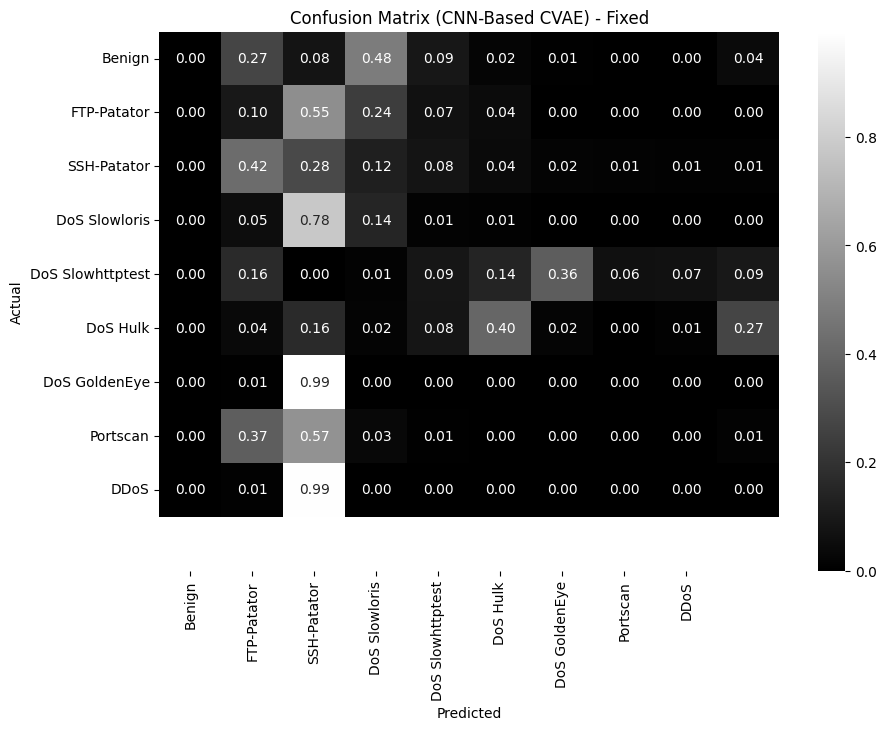

In [46]:
# ✅ 혼동 행렬 생성
cm = confusion_matrix(error_df["true_label"], error_df["predicted_label"])

plt.figure(figsize=(10, 7))
sns.heatmap(cm / np.sum(cm, axis=1)[:, np.newaxis], annot=True, fmt=".2f", cmap="gray", xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (CNN-Based CVAE) - Fixed")
plt.show()

In [47]:
threshold = np.percentile(normal_errors, 99)
error_df["predicted_label"] = np.digitize(error_df["reconstruction_error"], bins=np.linspace(0, threshold * 1.5, num_classes))

In [49]:
import tensorflow.keras.backend as K
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ z_mean 값을 NumPy 배열로 변환 (텐서 → NumPy)
z_mean_layer = model.get_layer("z_mean")
z_mean_function = K.function([model.input], [z_mean_layer.output])
z_mean_values = z_mean_function([X_test])[0]  # NumPy 배열로 변환

# ✅ t-SNE 적용 (X_test 샘플 수보다 perplexity가 작아야 함)
tsne = TSNE(n_components=2, perplexity=min(30, len(X_test)-1), random_state=42)
z_tsne = tsne.fit_transform(z_mean_values)

# ✅ t-SNE 결과 시각화
plt.figure(figsize=(10, 7))
sns.scatterplot(x=z_tsne[:, 0], y=z_tsne[:, 1], hue=y_test, palette="deep")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("Latent Space Representation (t-SNE)")
plt.show()

KeyboardInterrupt: 

In [40]:
sns.histplot(reconstruction_errors, bins=50, kde=True)
plt.axvline(threshold, color="red", linestyle="dashed")
plt.title("Reconstruction Error Distribution")
plt.show()

32833.8876393716

In [41]:
Q4_1 = error_df[error_df['true_class']==1]['reconstruction_error'].quantile(.05)

In [42]:
Q4_1

56566.34582271034

In [43]:
Q4_0 = error_df[error_df['true_class']==0]['reconstruction_error'].quantile(.90)

In [44]:
Q4_0

212490.4315525551

In [45]:
error_df[error_df['true_class']==0]['reconstruction_error'].max()

8507763095.584644

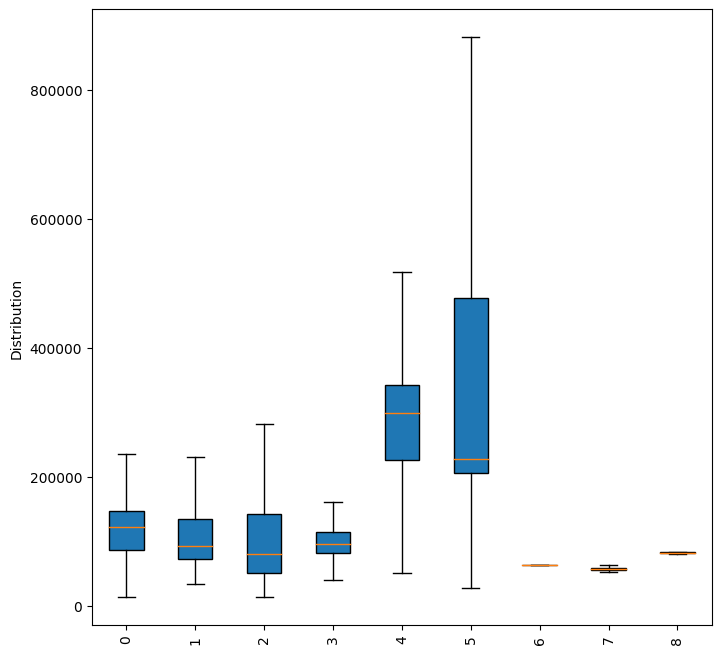

In [46]:
import matplotlib.pyplot as plt

# 데이터프레임 준비
true_class = error_df['true_class'].astype(str)
reconstruction_error = error_df['reconstruction_error']

# 박스 플롯 그리기
plt.figure(figsize=(8, 8))
plt.boxplot(
    [reconstruction_error[true_class == cls] for cls in sorted(true_class.unique())],
    labels=sorted(true_class.unique()),
    showfliers=False,
    vert=True,
    patch_artist=True
)

plt.ylabel('Distribution')
plt.xticks(rotation=90)
plt.show()


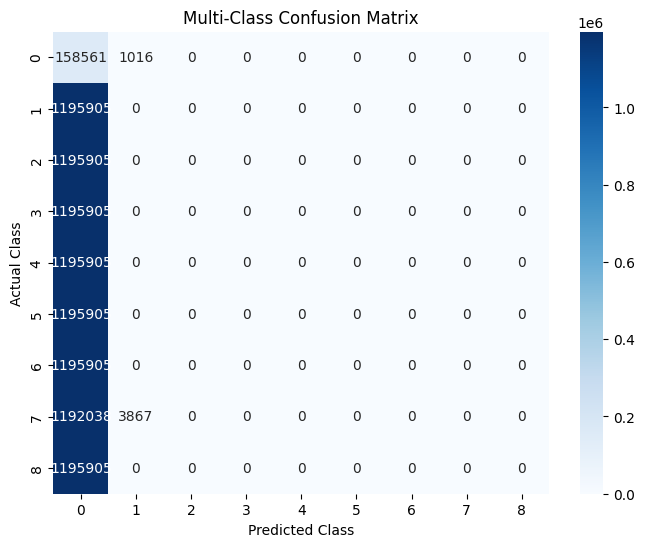

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ✅ 실제 값 (true_class) & 예측 값 설정
y_true = error_df['true_class']
y_pred = error_df['predicted_class']  # predicted_class는 이미 threshold 기반으로 설정했다고 가정

# ✅ Confusion Matrix 계산
conf_matrix = confusion_matrix(y_true, y_pred)

# ✅ Confusion Matrix 시각화 (다중 클래스)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(y_true.unique()), yticklabels=sorted(y_true.unique()))
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Multi-Class Confusion Matrix")
plt.show()


In [53]:
from sklearn.metrics import classification_report

# ✅ Precision, Recall, F1-score 계산 (다중 클래스)
report = classification_report(y_true, y_pred, target_names=[str(c) for c in sorted(y_true.unique())])
print(report)


C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.02      0.99      0.03    159577
           1       0.00      0.00      0.00   1195905
           2       0.00      0.00      0.00   1195905
           3       0.00      0.00      0.00   1195905
           4       0.00      0.00      0.00   1195905
           5       0.00      0.00      0.00   1195905
           6       0.00      0.00      0.00   1195905
           7       0.00      0.00      0.00   1195905
           8       0.00      0.00      0.00   1195905

    accuracy                           0.02   9726817
   macro avg       0.00      0.11      0.00   9726817
weighted avg       0.00      0.02      0.00   9726817



C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


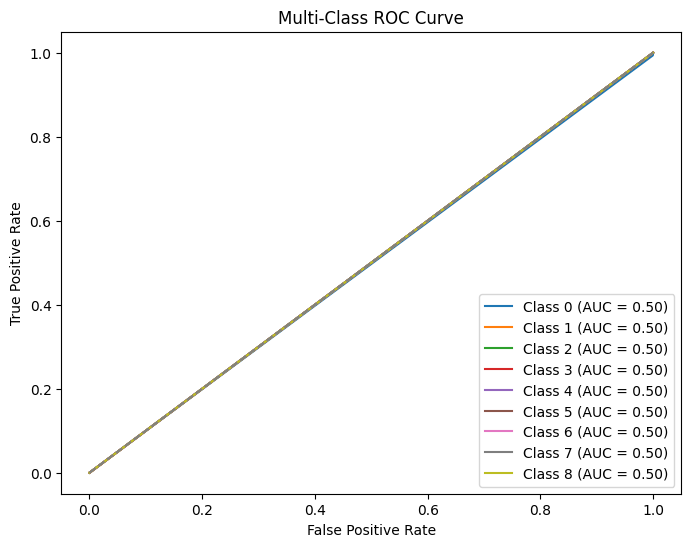

In [54]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# ✅ 라벨 Binarize (One-vs-Rest 방식)
classes = sorted(y_true.unique())  # 클래스 목록
y_true_bin = label_binarize(y_true, classes=classes)
y_pred_bin = label_binarize(y_pred, classes=classes)

# ✅ ROC Curve 계산
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

# ✅ 대각선 기준선 추가
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

# ✅ 그래프 설정
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend(loc="lower right")
plt.show()


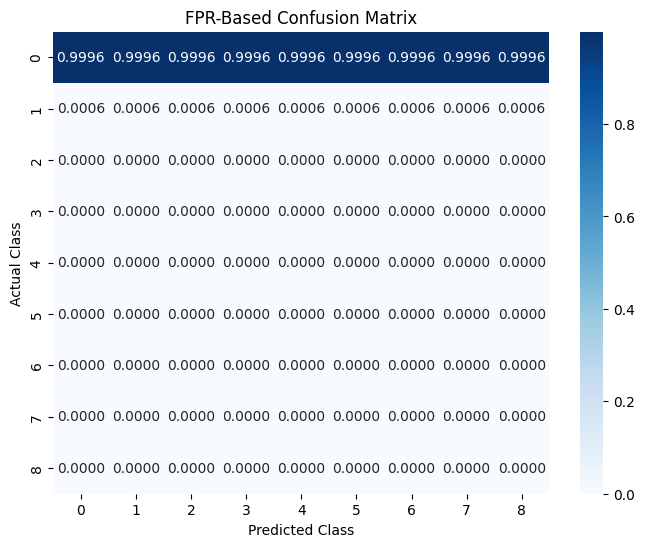

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ✅ 실제 값 & 예측 값 설정
y_true = error_df['true_class']
y_pred = error_df['predicted_class']

# ✅ Confusion Matrix 계산 (다중 클래스)
conf_matrix = confusion_matrix(y_true, y_pred)

# ✅ FPR 계산 (클래스별)
fpr_matrix = np.zeros_like(conf_matrix, dtype=np.float64)  # FPR 행렬 초기화

for i in range(conf_matrix.shape[0]):  # 각 클래스별 계산
    FP = conf_matrix[:, i].sum() - conf_matrix[i, i]  # False Positives (해당 열 합 - TP)
    TN = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])  # True Negatives
    if FP + TN > 0:
        fpr_matrix[i, :] = FP / (FP + TN)  # FPR 계산
    else:
        fpr_matrix[i, :] = 0  # 0으로 처리

# ✅ FPR Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(fpr_matrix, annot=True, fmt=".4f", cmap="Blues", xticklabels=sorted(y_true.unique()), yticklabels=sorted(y_true.unique()))
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("FPR-Based Confusion Matrix")
plt.show()


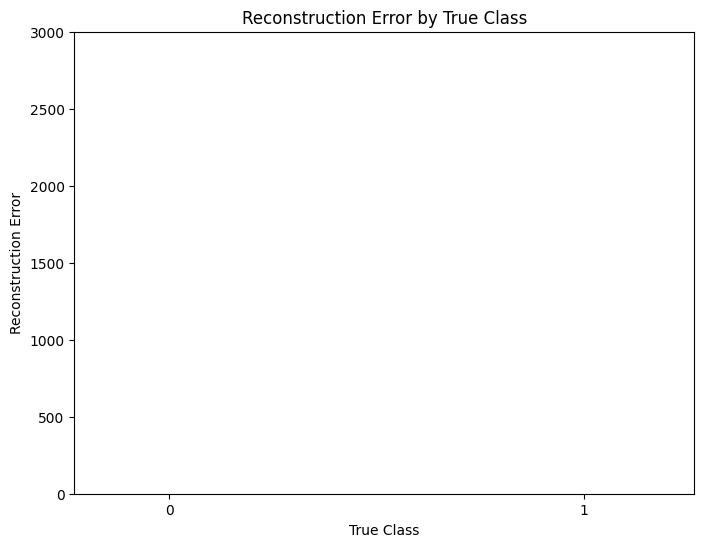

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data for plotting
true_class_0 = error_df[error_df['true_class'] == 0]['reconstruction_error']
true_class_1 = error_df[error_df['true_class'] == 1]['reconstruction_error']

# Create the figure and axes with a specified y-axis limit
plt.figure(figsize=(8, 6))

# Add jitter to avoid overlapping points in the scatter plot
x_0 = np.random.normal(1, 0.04, size=len(true_class_0))  # Jitter for class 0
x_1 = np.random.normal(2, 0.04, size=len(true_class_1))  # Jitter for class 1

# Create the scatter plot
plt.scatter(x_0, true_class_0, color='orange', alpha=0.6, edgecolor='black', label='Class 0')
plt.scatter(x_1, true_class_1, color='blue', alpha=0.6, edgecolor='black', label='Class 1')

# Set y-axis limit
plt.ylim(0, 3000)

# Set x-axis labels and adjust ticks
plt.xticks([1, 2], ['0', '1'])
plt.xlabel('True Class')

# Set y-axis label and title
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error by True Class')

# Display the plot
plt.show()


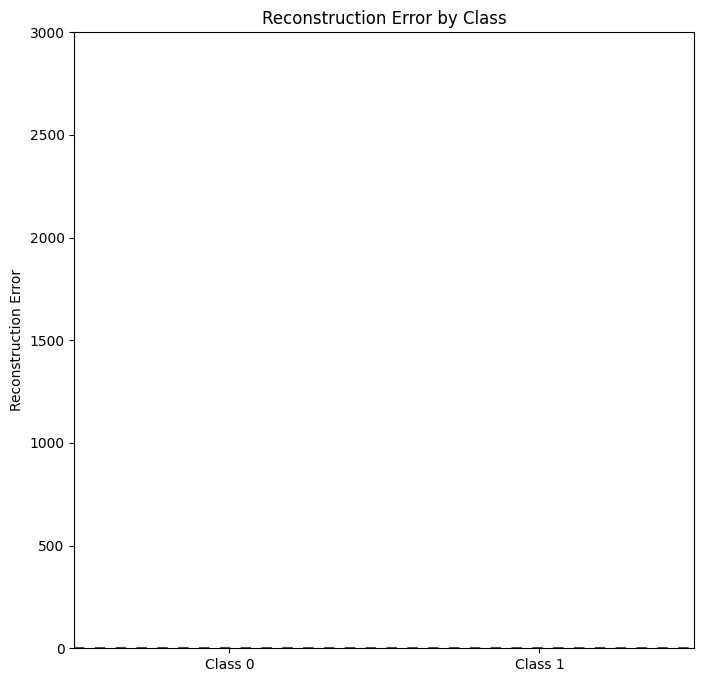

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data for plotting
true_class_0 = error_df[error_df['true_class'] == 0]['reconstruction_error']
true_class_1 = error_df[error_df['true_class'] == 1]['reconstruction_error']

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 8))

# Create a swarm plot equivalent using scatter plot with more jitter
x_0 = np.random.normal(1, 0.1, size=len(true_class_0))  # Increased jitter for class 0
x_1 = np.random.normal(2, 0.1, size=len(true_class_1))  # Increased jitter for class 1

ax.scatter(x_0, true_class_0, color='blue', alpha=0.6, label='Class 0', edgecolor='w', s=50)
ax.scatter(x_1, true_class_1, color='orange', alpha=0.6, label='Class 1', edgecolor='w', s=50)

# Create boxplots
ax.boxplot([true_class_0, true_class_1], positions=[1, 2], widths=0.6, patch_artist=True, 
           showfliers=False, boxprops=dict(facecolor='None', color='black'),
           medianprops=dict(color='black'), whiskerprops=dict(color='black'))

# Set x-axis labels
ax.set_xticks([1, 2])
ax.set_xticklabels(['Class 0', 'Class 1'])

# Add a horizontal line at the threshold
ax.axhline(y=0.03, xmin=0.0, xmax=1, dashes=(5, 5), color='red')

# Adjust y-axis limit to make sure the threshold line is visible
#ax.set_ylim(bottom=min(min(true_class_0), min(true_class_1)) - 0.01, 
#           top=max(max(true_class_0), max(true_class_1)) + 0.01)
ax.set_ylim(bottom=0, top=3000)
    
# Set labels and title
ax.set_ylabel('Reconstruction Error')
ax.set_title('Reconstruction Error by Class')

plt.show()


In [49]:


import numpy as np
from sklearn.metrics import f1_score

# Define the range of threshold values
threshold_range = np.arange(2590, 2650, 1)

# List to store F1 scores for each threshold
f1_scores = []

# Loop through each threshold and calculate F1 score
for threshold in threshold_range:
    y_pred = [0 if e < threshold else 1 for e in error_df.reconstruction_error.values]
    f1 = f1_score(error_df.true_class, y_pred)
    f1_scores.append(f1)

# Find the threshold with the highest F1 score
best_threshold = threshold_range[np.argmax(f1_scores)]
best_f1_score = max(f1_scores)

print(f"Best threshold: {best_threshold}")
print(f"Best F1 score: {best_f1_score}")

# Optionally, you can plot the F1 scores across the threshold range
plt.plot(threshold_range, f1_scores, marker='o')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.show()


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [ ]:
# 그래프 보고 threshold 결정 42.19124597192374
threshold = 2590

In [ ]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
            label= "Normal" if name == 0 else "Fall")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.set_ylim(0, 40)
ax.legend()
plt.title("Reconstruction ierror for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have already defined LABELS, threshold, and y_pred

LABELS = ["Attack", "Normal"]

y_pred = [0 if e < threshold else 1 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

# Create the figure and axis
plt.figure(figsize=(12, 12))
fig, ax = plt.subplots()

# Plot the confusion matrix using imshow
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)

# Add color bar
plt.colorbar(cax)

# Set the labels for the axes
ax.set_xticks(np.arange(len(LABELS)))
ax.set_yticks(np.arange(len(LABELS)))

ax.set_xticklabels(LABELS)
ax.set_yticklabels(LABELS)

# Set labels and title
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix')

# Annotate the confusion matrix with the counts
for i in range(len(LABELS)):
    for j in range(len(LABELS)):
        ax.text(j, i, format(conf_matrix[i, j], 'd'),
                ha="center", va="center",
                color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')
print ('Accuracy Score :',accuracy_score(error_df.true_class, y_pred) )
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

In [ ]:
from sklearn.metrics import roc_curve, auc

# Assuming y_test and reconstruction_error have been defined
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Extract the true labels and reconstruction errors from error_df
y_true = error_df['true_class']
y_scores = error_df['reconstruction_error']

# Compute the False Positive Rate (FPR) and True Positive Rate (TPR) for different thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')

# Set plot labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Display the plot
plt.show()


In [ ]:
# If error_df.true_class is a nested structure, flatten it
y_test = error_df.true_class.apply(lambda x: int(x[0][0]) if isinstance(x, list) else int(x))

# Ensure y_pred is a list of integers
y_pred = [0 if e < threshold else 1 for e in error_df.reconstruction_error.values]

# Now calculate the metrics
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print('Accuracy Score:', accuracy_score(y_test, y_pred))
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)


In [ ]:
print(roc_auc)

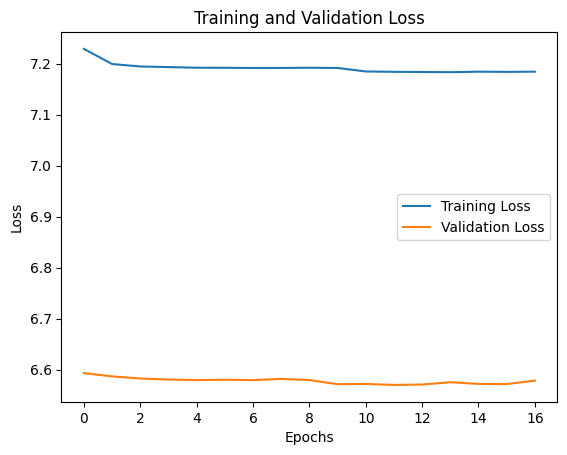

34881/34881 [==============================] - 55s 2ms/step


/var/folders/lt/dt43ws7s4_z4rrsjwvzmwz740000gn/T/ipykernel_16133/3651740282.py:27: RuntimeWarning: invalid value encountered in divide
  sns.heatmap(cm / np.sum(cm, axis=1)[:, np.newaxis], annot=True, fmt=".2f", cmap="gray", xticklabels=labels, yticklabels=labels)


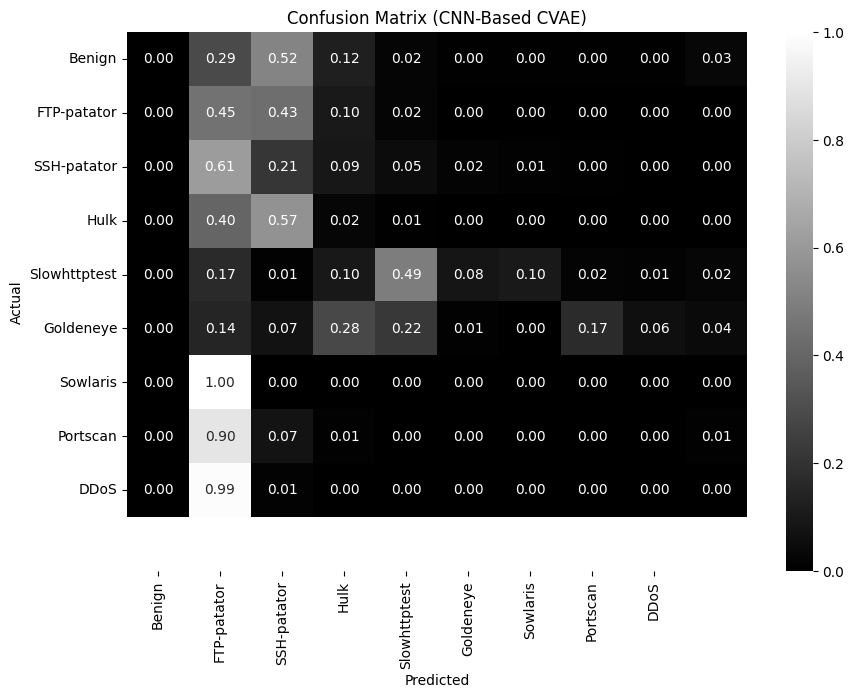

/opt/homebrew/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


🔹 Precision: 0.0970
🔹 Recall: 0.1267
🔹 F1-score: 0.0932


ValueError: Number of classes, 10, does not match size of target_names, 9. Try specifying the labels parameter

In [34]:
# ✅ Training & Validation Loss 그래프 출력
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history.get('val_loss', []), label='Validation Loss')  # NaN 방지
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

# ✅ 테스트 데이터 예측 및 재구성 오류 계산
X_test_pred = model.predict(X_test)
reconstruction_errors = np.mean(np.square(X_test - X_test_pred), axis=1)  # MSE 사용

# ✅ 임계값 설정 (정상 데이터의 95% 기준)
threshold = np.percentile(reconstruction_errors, 95)

# ✅ 공격 유형별로 분류 (9개 클래스)
y_pred_labels = np.digitize(reconstruction_errors, bins=np.linspace(0, threshold * 1.5, num_classes))


# ✅ 혼동 행렬 생성 (9개 클래스 고려)
cm = confusion_matrix(y_test, y_pred_labels)

labels = ["Benign", "FTP-patator", "SSH-patator", "Hulk", "Slowhttptest", "Goldeneye", "Sowlaris", "Portscan", "DDoS"]

plt.figure(figsize=(10, 7))
sns.heatmap(cm / np.sum(cm, axis=1)[:, np.newaxis], annot=True, fmt=".2f", cmap="gray", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (CNN-Based CVAE)")
plt.show()

# ✅ 정확도, 정밀도(Precision), 재현율(Recall), F1-score 계산
precision = precision_score(y_test, y_pred_labels, average='weighted')
recall = recall_score(y_test, y_pred_labels, average='weighted')
f1 = f1_score(y_test, y_pred_labels, average='weighted')

print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall: {recall:.4f}")
print(f"🔹 F1-score: {f1:.4f}")

# ✅ Classification Report 출력
print("\n📌 Classification Report:\n", classification_report(y_test, y_pred_labels, target_names=labels))